In [1]:
# Imports Libs for:

# Web scraping
import requests
from bs4 import BeautifulSoup
from myfuncs import * # Self-defined functions for pulling data from specific sites
from dotenv import load_dotenv
import os

# Data analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score #, calinski_harabasz_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd

# Set random seed
np.random.seed(42)


/Users/ningnong/Desktop/MADS/SIADS696_MilestoneII/Air Travel Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data Extraction & Preprocessing

## State-level Data

### FRED API

In [2]:
url = 'https://fred.stlouisfed.org/release/tables?rid=249&eid=259462' # Median household income by state
variable = 'Median Household Income'

income_df = extract_FRED_data(url,variable)
income_df.head()

,State Name,Median Household Income [Current Dollars],Year
0,The United States,80610.0,2023
1,Alabama,60660.0,2023
2,Alaska,98190.0,2023
3,Arizona,82660.0,2023
4,Arkansas,63250.0,2023


In [3]:
url = 'https://fred.stlouisfed.org/release/tables?eid=840687&rid=116'
variable = 'Unemployment Rate'
UE_df = extract_FRED_data(url,variable)
UE_df.head()

,State Name,Unemployment Rate [Percent],Year
0,Alabama,2.5,2023
1,Alaska,4.2,2023
2,Arizona,3.9,2023
3,Arkansas,3.3,2023
4,California,4.8,2023


In [4]:
url = 'https://fred.stlouisfed.org/release/tables?eid=259194&rid=118'
variable = 'Population'
pop_df = extract_FRED_data(url,variable)
pop_df.head()

,State Name,Population [Thousands of Persons],Year
0,Alabama,5108.468,2023
1,Alaska,733.406,2023
2,Arizona,7431.344,2023
3,Arkansas,3067.732,2023
4,California,38965.193,2023


In [5]:
# Compile FRED data: income_df, UE_df, pop_df

fred_df = pd.merge(income_df, UE_df, on=['State Name', 'Year'], how='inner') \
           .merge(pop_df, on=['State Name', 'Year'], how='inner')
# fred_df.to_csv('assets/FRED_data.csv', index=None)
# fred_df = pd.read_csv('assets/FRED_data.csv')
fred_df.head()

,State Name,Median Household Income [Current Dollars],Year,Unemployment Rate [Percent],Population [Thousands of Persons]
0,Alabama,60660.0,2023,2.5,5108.468
1,Alaska,98190.0,2023,4.2,733.406
2,Arizona,82660.0,2023,3.9,7431.344
3,Arkansas,63250.0,2023,3.3,3067.732
4,California,89870.0,2023,4.8,38965.193


### US Census Bureau: American Community Survey (ACS)

In [6]:
api_key_USCB = os.getenv('API_KEY_USCB')

acs_2023_df = extract_and_preprocess_ACS_data(api_key=api_key_USCB, year=2023, state_code=None)
acs_2022_df =  extract_and_preprocess_ACS_data(api_key=api_key_USCB, year=2022, state_code=None)

In [7]:
acs_df = pd.concat([acs_2023_df,acs_2022_df],ignore_index=True)
acs_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065


In [8]:
acs_df.Year.unique()

array([2023, 2022])

### State Information

In [9]:
# Map state FIPS code to state names

state_df = extract_state_mapper()
state_df.to_csv('assets/state_info.csv', index=None)
# state_df = pd.read_csv('assets/state_info.csv')
state_df.head()

,State Name,State Code (FIPS),State Code (USPS)
0,Alabama,01,AL
1,Alaska,02,AK
2,Arizona,04,AZ
3,Arkansas,05,AR
4,California,06,CA


In [10]:
# Merge state name to acs_df based on FIPS code
acs_df= pd.merge(acs_df, state_df, on = 'State Code (FIPS)', how = 'left').dropna()
acs_df.to_csv('assets/acs_df.csv',index=None)
# acs_df = pd.read_csv('assets/acs_df.csv')
acs_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Name,State Code (USPS)
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,Alabama,AL
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,Alaska,AK
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,Arizona,AZ
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,Arkansas,AR
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,California,CA


### Air Travel Data

In [11]:
# Domestic flight by origin airports (2023)
# Data: Flight volume by Airport Code; this will be our main dataset
# Extraction: csv download from https://equity-data.dot.gov/datasets/17e9a793c7cf47c8b64dab92da55dfe5/about

fp_flights = 'assets/T100_Domestic_Market_and_Segment_Data_-3591723781169319541.csv'
flight_df = pd.read_csv(fp_flights)
flight_df.columns = flight_df.columns.str.title()
flight_df.rename(columns={'Origin': 'Airport Code'}, inplace=True)
flight_df.head() # Here, origin airport names ('origin') are abbreviated by the respective Airport Codes.

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334


In [12]:
# Map airports to their respective states based on Airport Code
df_airports = extract_airport_info()
df_airports.head()

,Airport Code,Airport Name,City,State Code (USPS)
0,ABE,Lehigh Valley International,Allentown,PA
1,ABI,Abilene Regional,Abilene,TX
2,ABQ,Albuquerque International,Albuquerque,NM
3,ACK,Nantucket Memorial,Nantucket,MA
4,ADQ,Kodiak,Kodiak,AK


In [13]:
# df_airports['Airport Code'].unique() # ok
# df_airports['State Code (USPS)'].unique() # contain trailing whitespaces
df_airports['State Code (USPS)'] = df_airports['State Code (USPS)'].str.strip()
df_airports['State Code (USPS)'].unique() 

array(['PA', 'TX', 'NM', 'MA', 'AK', 'GA', 'NY', 'IA', 'WI', 'NC', 'MI',
       'CT', 'CA', 'ME', 'AL', 'MT', 'ND', 'TN', 'ID', 'PR', 'LA', 'VT',
       'MD', 'SC', 'OH', 'CO', 'WV', 'FL', 'DC', 'MN', 'OR', 'IN', 'NJ',
       'SD', 'WA', 'MS', None, 'Oahu, HI', 'KS', 'Hawaii, HI', 'WY', 'NV',
       'KY', 'HI', 'AR', 'NE', 'MO', 'IL', 'NH', 'OK', 'VA', 'AZ', 'RI',
       'UT', 'Mariana Islands', 'VI'], dtype=object)

In [14]:
# Add state info (State Code (USPS)) to flight_df
flight_df = pd.merge(flight_df,df_airports, on='Airport Code', how='left').dropna()
flight_df.head()

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS)
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732,Hartsfield International,Atlanta,GA
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972,Denver International,Denver,CO
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642,Dallas/Ft.Worth International,Dallas/Ft. Worth,TX
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924,Chicago O'Hare International,Chicago,IL
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334,McCarran International,Las Vegas,NV


In [15]:
flight_df[flight_df.isna().any(axis=1)] 

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS)


In [16]:
# Add complete state-level info to flight_df 
flight_df = pd.merge(flight_df, state_df, on="State Code (USPS)", how='left')
flight_df.head()

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732,Hartsfield International,Atlanta,GA,Georgia,13
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972,Denver International,Denver,CO,Colorado,08
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642,Dallas/Ft.Worth International,Dallas/Ft. Worth,TX,Texas,48
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924,Chicago O'Hare International,Chicago,IL,Illinois,17
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334,McCarran International,Las Vegas,NV,Nevada,32


In [17]:
flight_df[flight_df.isna().any(axis=1)] #some rows failed to merge based on state code

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
29,30,2023,HNL,8683570,8712287,84008,84342.0,403171072,48837780,Honolulu International,Honolulu,"Oahu, HI",NaN,NaN
41,42,2023,SJU,5356377,5369531,46433,45366.0,132448723,5717439,Luis Munoz Marin International,San Juan,PR,NaN,NaN
70,71,2023,KOA,2055155,2061662,21244,21311.0,41430534,1187629,Kona International at Ke-Ahole,Kona,"Hawaii, HI",NaN,NaN
103,110,2023,STT,701396,701405,13923,14620.0,275691,0,Cyril E. King,St. Thomas,VI,NaN,NaN
106,113,2023,ITO,684175,684329,9109,9123.0,13325009,2,General Lyman Field,Hilo,"Hawaii, HI",NaN,NaN
133,143,2023,BQN,425461,425461,3180,3413.0,18285407,0,Rafael Hernandez,Aguadilla,PR,NaN,NaN
162,181,2023,STX,235368,235538,8806,8932.0,121732,0,Henry E. Rholsen,St. Croix,VI,NaN,NaN
197,246,2023,SPN,73233,73233,12353,12209.0,1174097,0,Saipan International,Saipan,Mariana Islands,NaN,NaN


In [18]:
flight_na = flight_df[flight_df.isna().any(axis=1)] 
flight_na['State Code (USPS)'].unique()

array(['Oahu, HI', 'PR', 'Hawaii, HI', 'VI', 'Mariana Islands'],
      dtype=object)

In [19]:
hawaii_state_info = state_df[state_df['State Code (USPS)'] == 'HI']
hawaii_FIPS = hawaii_state_info['State Code (FIPS)'].values[0]
hawaii_USPS = hawaii_state_info['State Code (FIPS)'].values[0]
hawaii_state_name = hawaii_state_info['State Code (FIPS)'].values[0]

hawaii_state_info

,State Name,State Code (FIPS),State Code (USPS)
11,Hawaii,15,HI


In [20]:
# Only Hawaii is a state. Mariana Islands, Puerto Rico (PR) and the U.S. Virgin Islands (VI) are not considered states in the United States
# Perform correction for Hawaii
flight_df.loc[flight_df['State Code (USPS)'].str.contains('HI'), ['State Code (USPS)', 'State Code (FIPS)', 'State Name']] = ['HI', 15, 'Hawaii']
flight_df[flight_df['State Code (USPS)'] == 'Hawaii, HI']

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)


In [21]:
flight_df[flight_df['State Code (USPS)'] == 'HI']

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
29,30,2023,HNL,8683570,8712287,84008,84342.0,403171072,48837780,Honolulu International,Honolulu,HI,Hawaii,15
52,53,2023,OGG,3592010,3606698,41434,41457.0,23053619,24635,Kahului,Kahului,HI,Hawaii,15
70,71,2023,KOA,2055155,2061662,21244,21311.0,41430534,1187629,Kona International at Ke-Ahole,Kona,HI,Hawaii,15
77,78,2023,LIH,1799784,1800727,18376,18495.0,15552114,397549,Lihue,Kauai Island,HI,Hawaii,15
106,113,2023,ITO,684175,684329,9109,9123.0,13325009,2,General Lyman Field,Hilo,HI,Hawaii,15


In [22]:
flight_df[flight_df.isna().any(axis=1)] 

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
41,42,2023,SJU,5356377,5369531,46433,45366.0,132448723,5717439,Luis Munoz Marin International,San Juan,PR,NaN,NaN
103,110,2023,STT,701396,701405,13923,14620.0,275691,0,Cyril E. King,St. Thomas,VI,NaN,NaN
133,143,2023,BQN,425461,425461,3180,3413.0,18285407,0,Rafael Hernandez,Aguadilla,PR,NaN,NaN
162,181,2023,STX,235368,235538,8806,8932.0,121732,0,Henry E. Rholsen,St. Croix,VI,NaN,NaN
197,246,2023,SPN,73233,73233,12353,12209.0,1174097,0,Saipan International,Saipan,Mariana Islands,NaN,NaN


In [23]:
# These are non-state rows (PR, VI, Mariana Islands), let's drop them
flight_df.dropna(inplace=True)
# flight_df[flight_df.isna().any(axis=1)]  # No more NA rowsß
# flight_df.to_csv('assets/flight_data.csv',index=None)
# flight_df = pd.read_csv('assets/flight_data.csv')
flight_df.head()

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732,Hartsfield International,Atlanta,GA,Georgia,13
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972,Denver International,Denver,CO,Colorado,08
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642,Dallas/Ft.Worth International,Dallas/Ft. Worth,TX,Texas,48
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924,Chicago O'Hare International,Chicago,IL,Illinois,17
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334,McCarran International,Las Vegas,NV,Nevada,32


In [24]:
flight_df.columns

Index(['Objectid', 'Year', 'Airport Code', 'Enplanements', 'Passengers',
       'Departures', 'Arrivals', 'Freight', 'Mail', 'Airport Name', 'City',
       'State Code (USPS)', 'State Name', 'State Code (FIPS)'],
      dtype='object')

# EDA

In [25]:
# Filter state-level socio-demographic features based on the presence/absence of correlation with enplanements. (Qn: Which sociodemographic variables should we include for clustering of states? )

# First, calculate state statistics for Enplanement (air travel volume) in flight_df
flight_byState = flight_df[['State Name','Enplanements']].groupby('State Name').mean().reset_index()

# Create a df to explore the relationships for 2023 data
df = pd.merge(flight_byState, acs_df.query('Year==2023'), on='State Name', how='left')
df.head()

,State Name,Enplanements,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Code (USPS)
0,Alabama,6.697678e+05,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,AL
1,Alaska,2.112405e+05,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,AK
2,Arizona,1.227266e+07,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,AZ
3,Arkansas,1.096748e+06,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,AR
4,California,5.954076e+06,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,CA


In [26]:
df.select_dtypes('number').columns

Index(['Enplanements', 'Median Household Income', 'Per Capita Income',
       'Gini Index of Income Inequality', 'Total Population', 'Median Age',
       'Median Home Value', 'Year', 'Unemployment Rate', 'Percent Foreigners'],
      dtype='object')

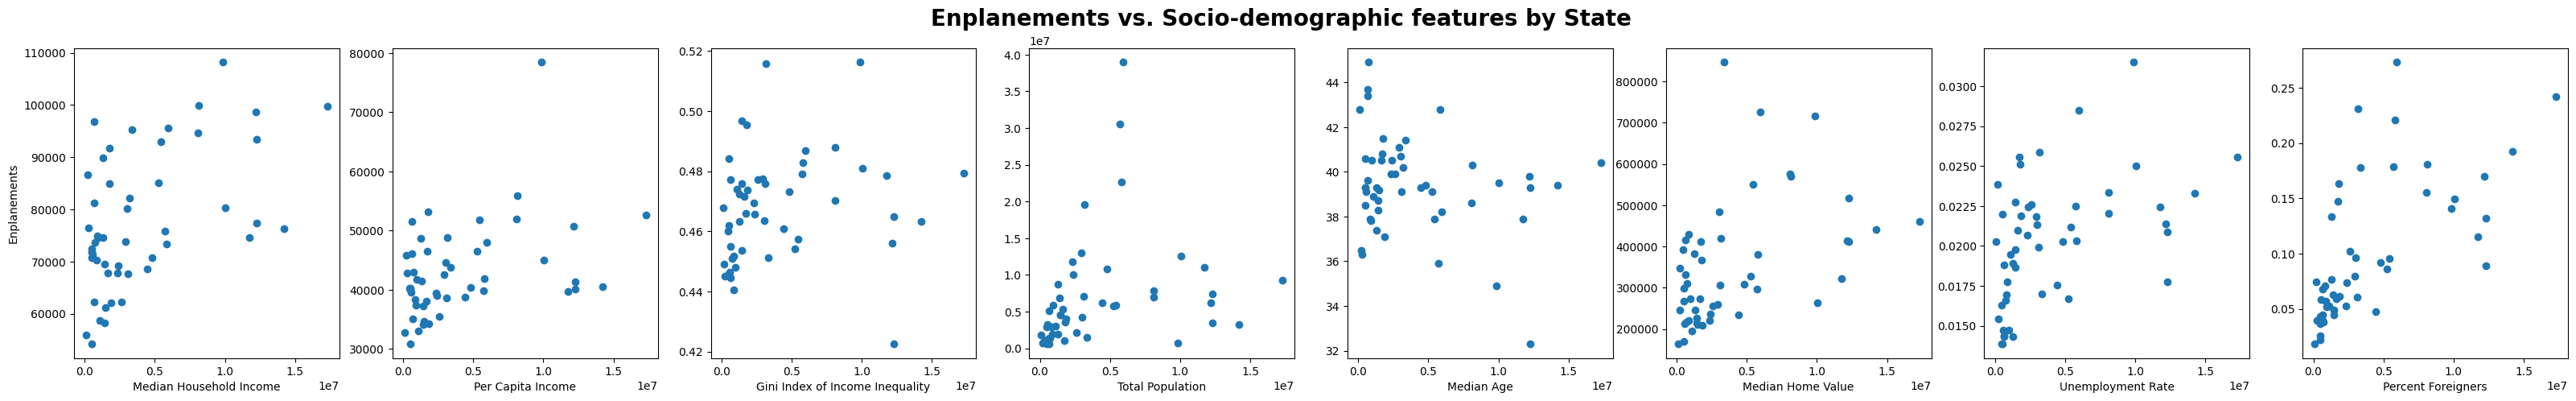

In [27]:
sociodemo_cols = [
    'Median Household Income', 
    'Per Capita Income',
    'Gini Index of Income Inequality',
    'Total Population', 
    'Median Age',
    'Median Home Value', 
    'Unemployment Rate',
    'Percent Foreigners'
    ]

plt.figure(figsize=(5*len(sociodemo_cols), 5))  
for i in range(len(sociodemo_cols)):
    plt.subplot(1,len(sociodemo_cols),i+1)
    plt.scatter(df['Enplanements'],df[sociodemo_cols[i]])
    plt.xlabel(sociodemo_cols[i])
    if i==0:
        plt.ylabel('Enplanements')
    plt.suptitle('Enplanements vs. Socio-demographic features by State', fontsize=20, weight='bold')
plt.savefig('visualizations/enplanements_vs_sociodemographics.png', dpi=300)
plt.show()

- Mainly positive, linear correlations between Enplanements and the selected sociodemographic variables except Median age. --> let's drop median age col from subsequent clustering.
- Most sociodemographic variables appear to be right-skewed

In [28]:
df.drop(columns=['Median Age'],inplace=True)

In [29]:
acs_df.Year.unique()
acs_df.columns

Index(['Median Household Income', 'Per Capita Income',
       'Gini Index of Income Inequality', 'Total Population', 'Median Age',
       'Median Home Value', 'State Code (FIPS)', 'Year', 'Unemployment Rate',
       'Percent Foreigners', 'State Name', 'State Code (USPS)'],
      dtype='object')

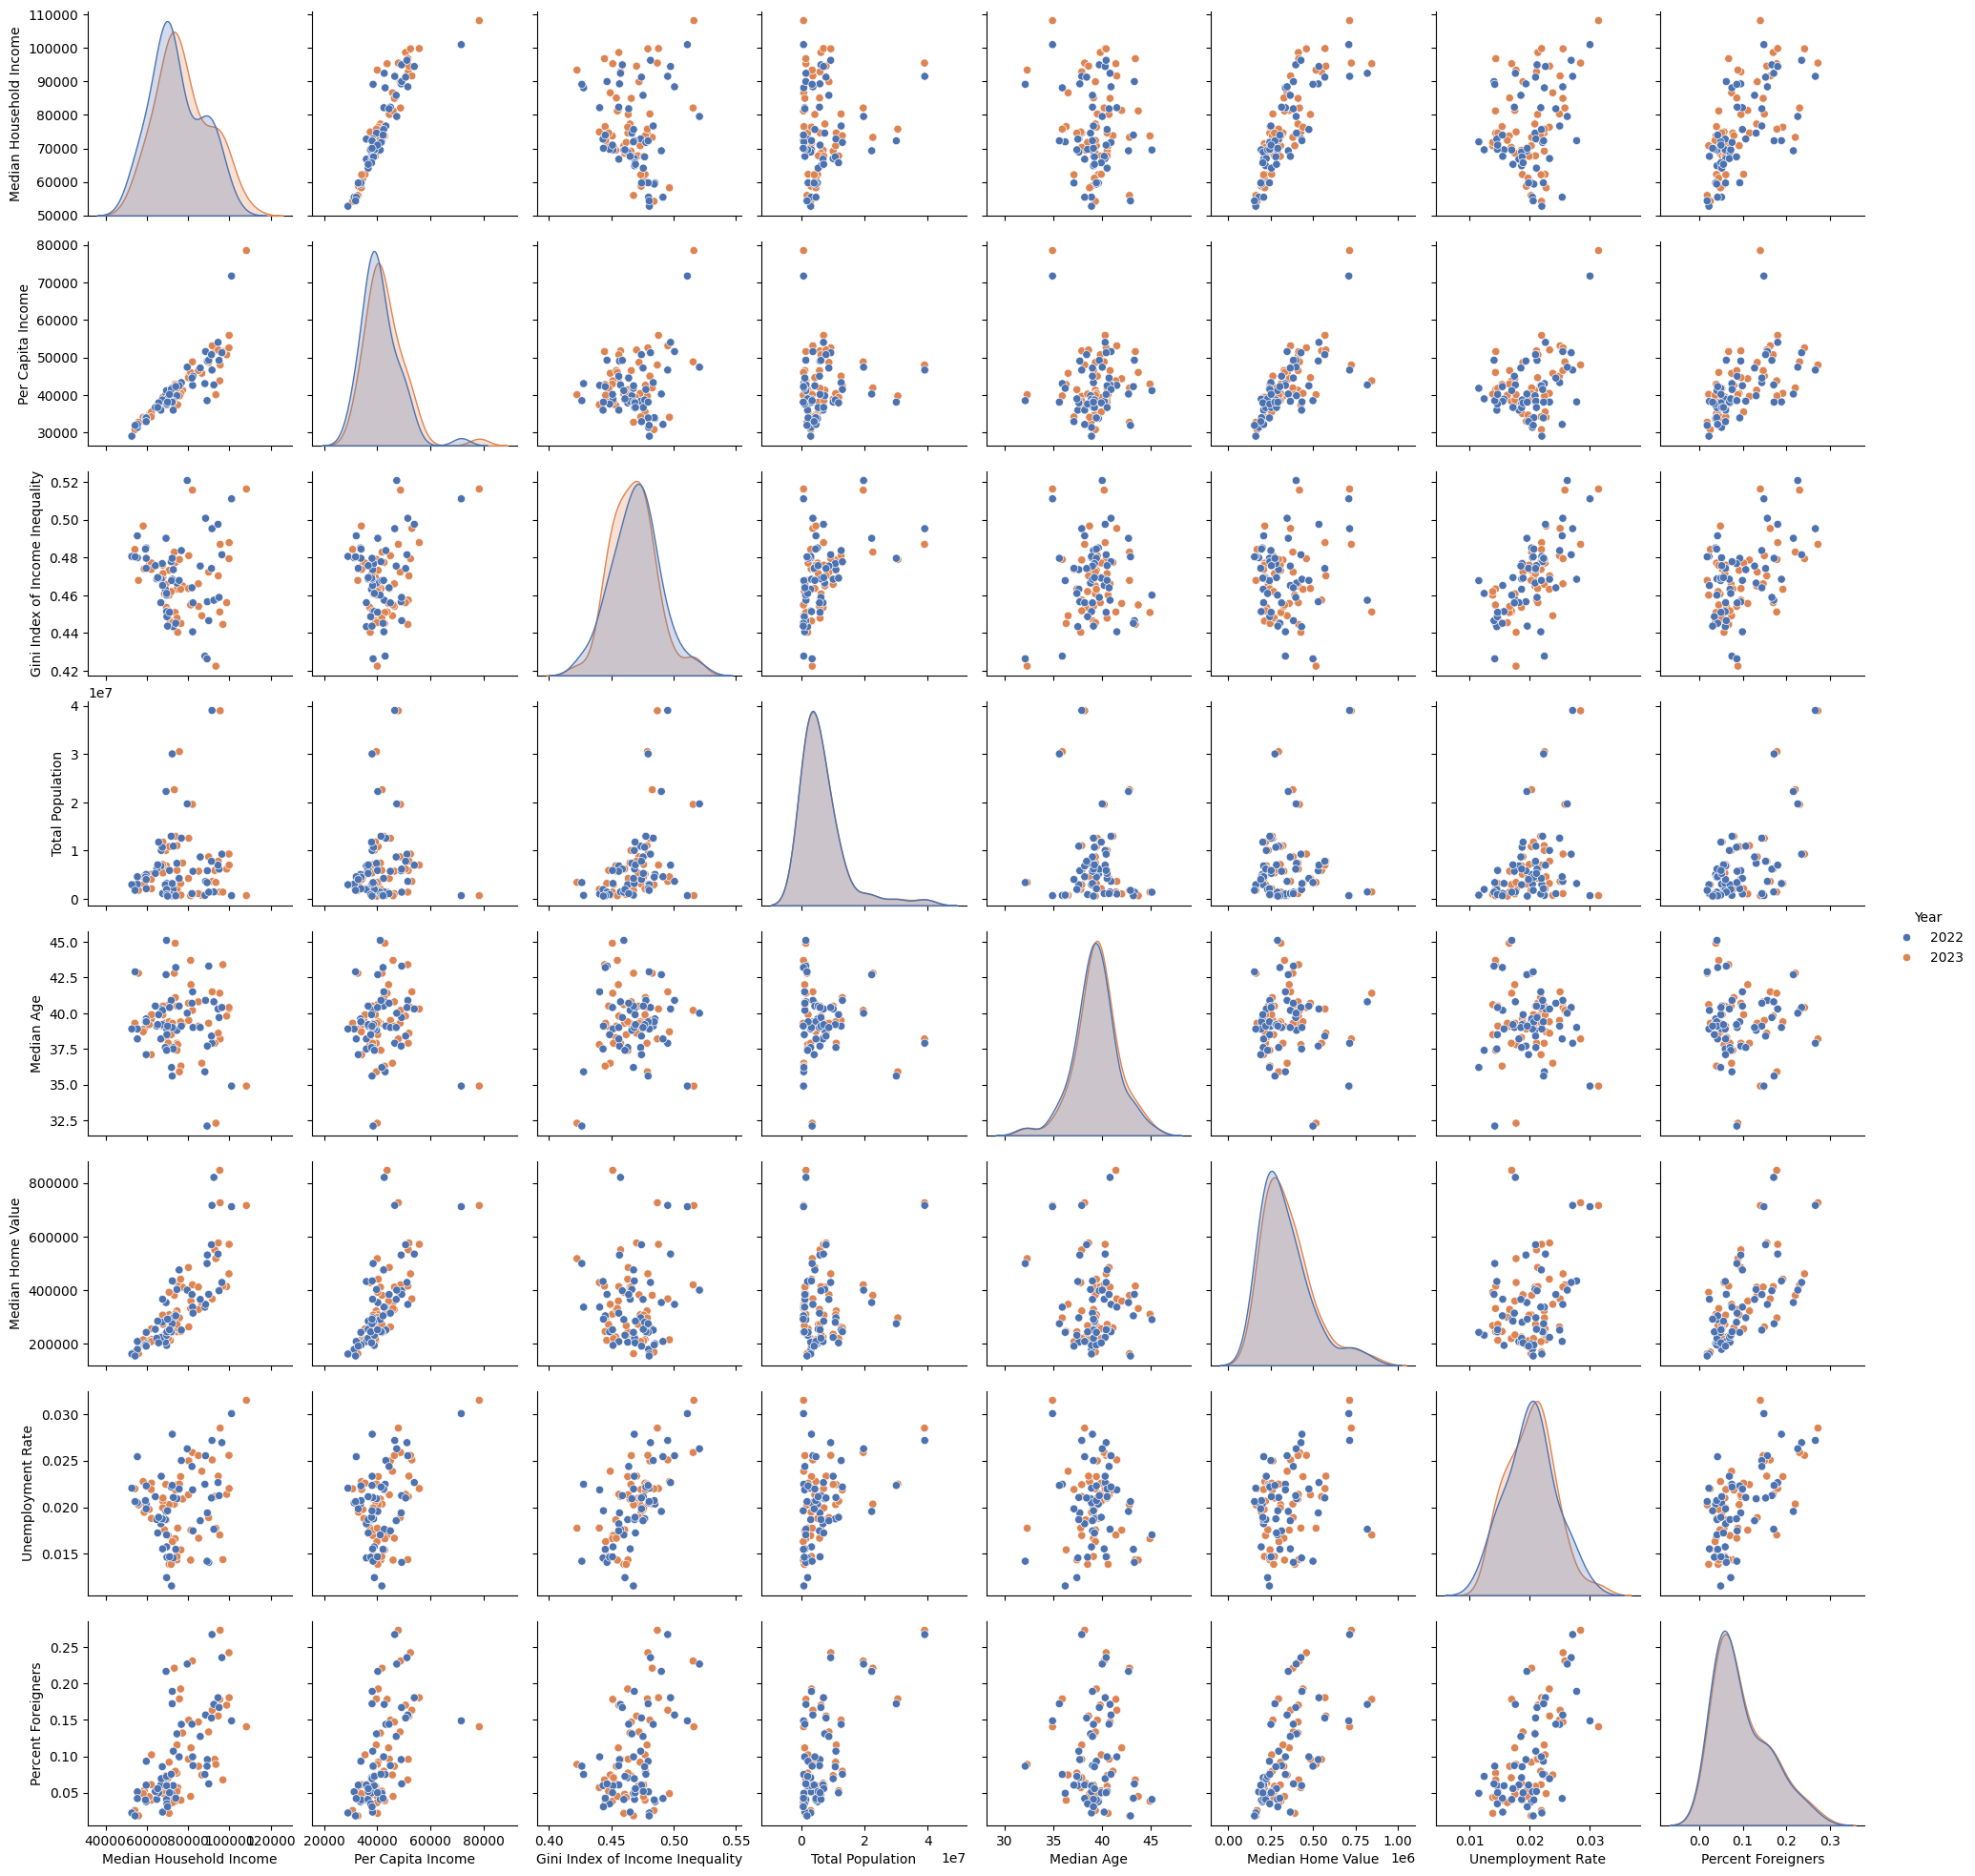

In [30]:
# Create a SPLOM to see the relationships/correlations among Socio-demographic features
# SPLOM for 2022 and 2023 data (SPLOM by year)
img_name = 'acs_SPLOMs_byYear'

tmp = acs_df[[col for col in acs_df.columns if 'State' not in col]].copy()
sns.pairplot(tmp, hue="Year", palette='deep')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

- Similar distributions for 2022 and 2023. Let's use 2023 for analysis 

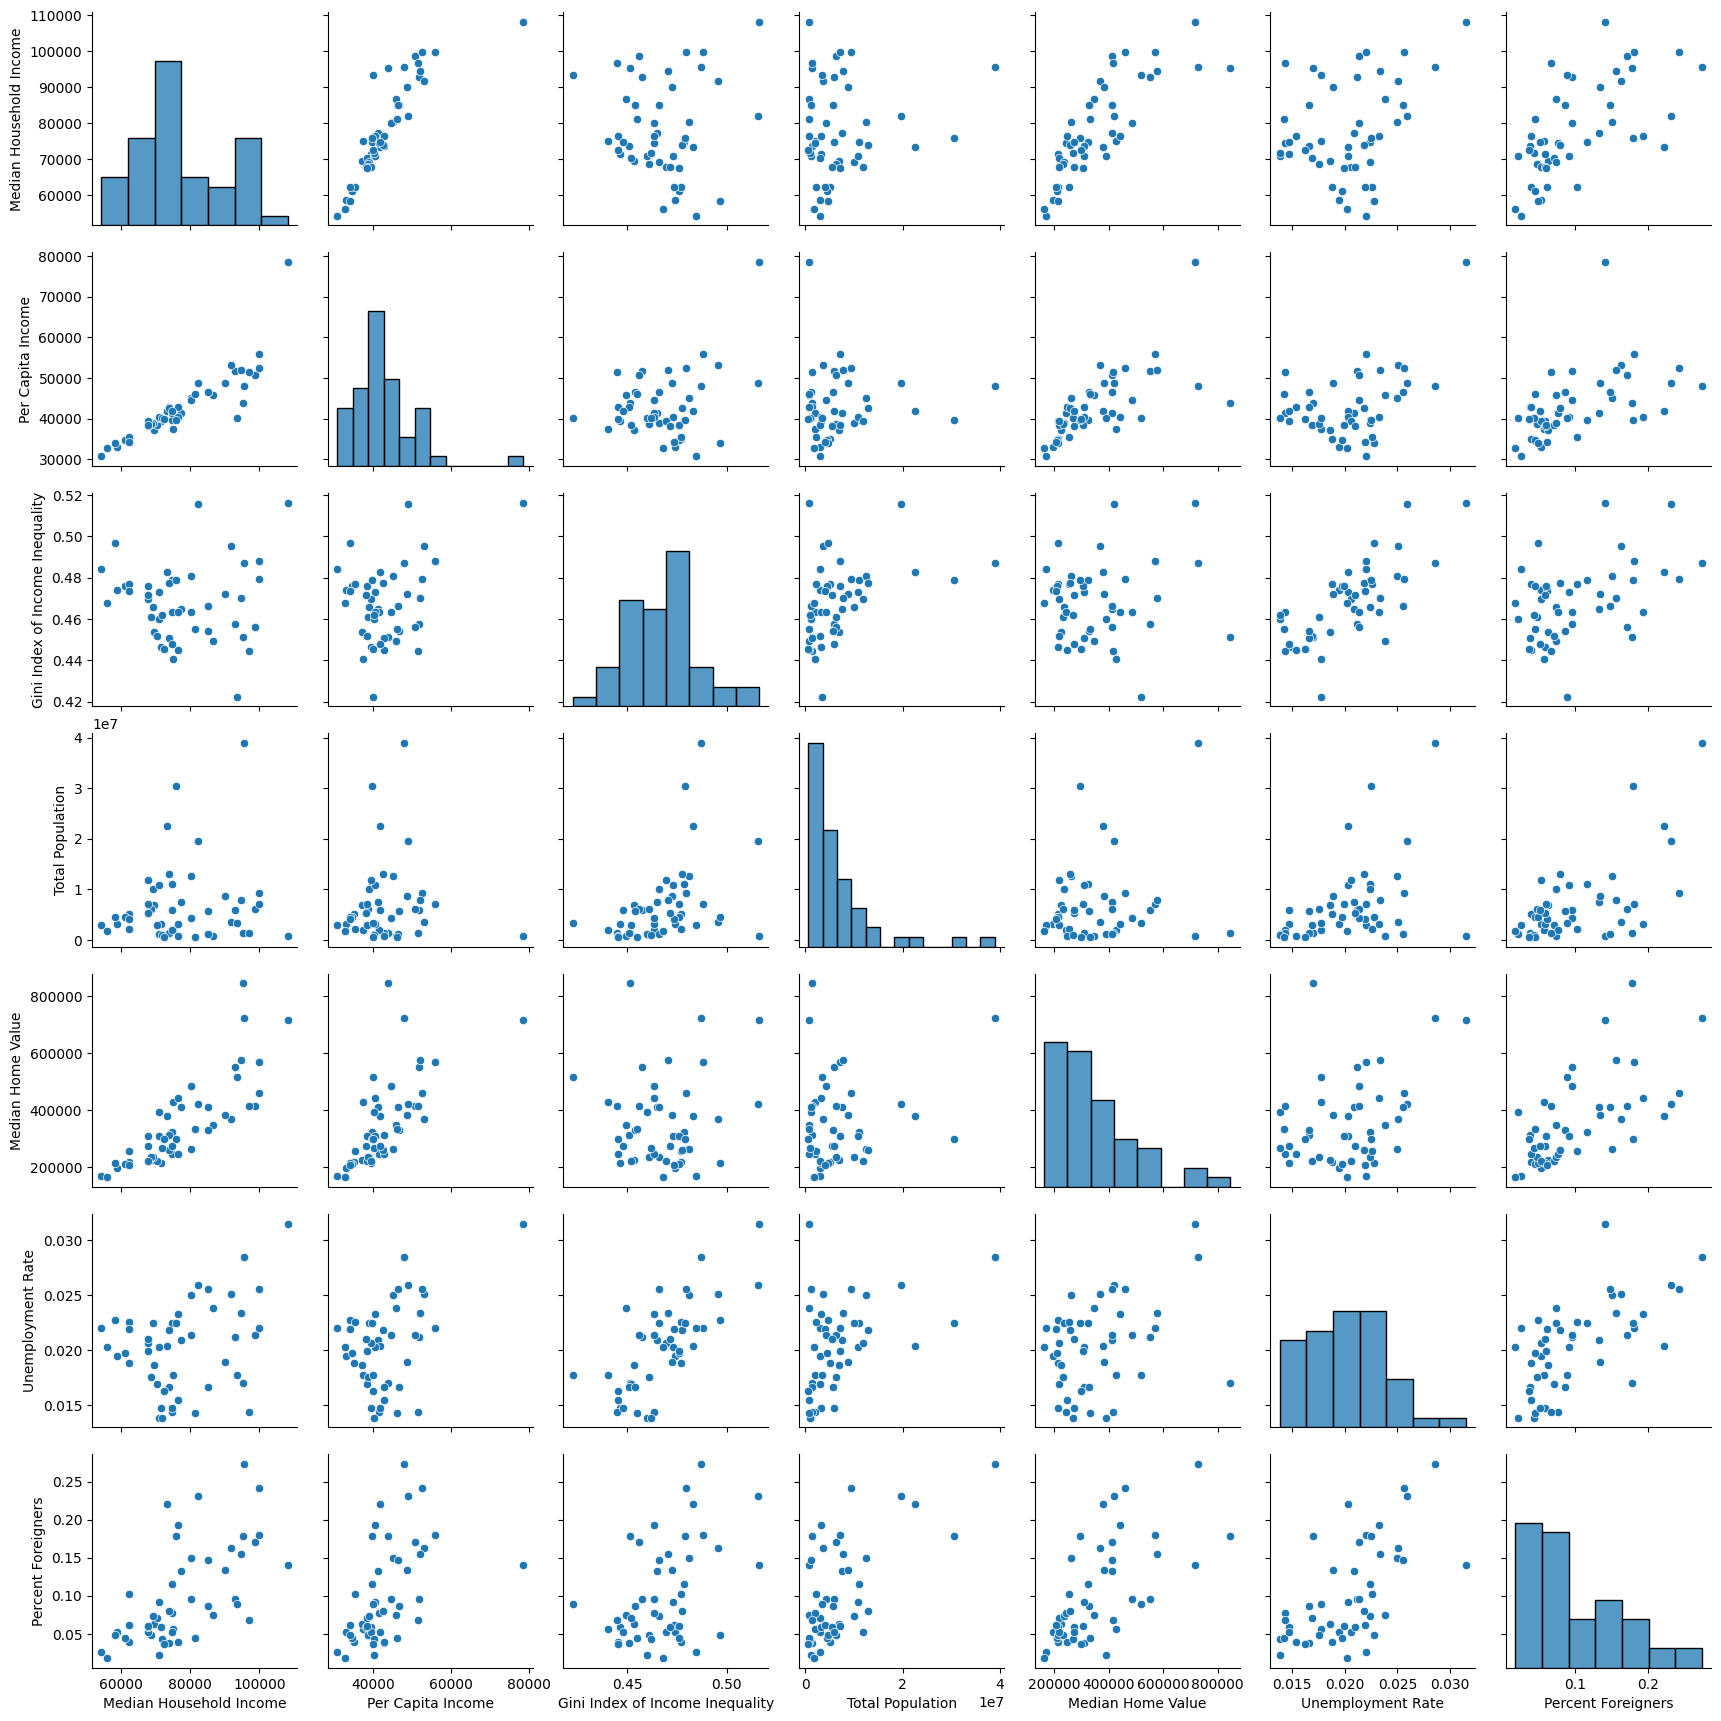

In [31]:
# SPLOM for 2023 data
sns.pairplot(df[[col for col in df.columns if col not in ['Enplanements','Year','State Code (FIPS)']]])
# plt.savefig('visualizations/SPLOM_sociodemographics.png',dpi=300)
plt.show()

# Unsupervised Learning

## Dimensionality Reduction

### PCA

In [32]:
df.head()

,State Name,Enplanements,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Code (USPS)
0,Alabama,6.697678e+05,62212.0,35046.0,0.4771,5108468.0,216600.0,01,2023,0.018804,0.039766,AL
1,Alaska,2.112405e+05,86631.0,45792.0,0.4492,733406.0,347500.0,02,2023,0.023868,0.074408,AK
2,Arizona,1.227266e+07,77315.0,41290.0,0.4650,7431344.0,411200.0,04,2023,0.020882,0.131999,AZ
3,Arkansas,1.096748e+06,58700.0,33012.0,0.4740,3067732.0,195700.0,05,2023,0.019464,0.052919,AR
4,California,5.954076e+06,95521.0,48013.0,0.4870,38965193.0,725800.0,06,2023,0.028509,0.273065,CA


In [33]:
df.select_dtypes('number').columns

Index(['Enplanements', 'Median Household Income', 'Per Capita Income',
       'Gini Index of Income Inequality', 'Total Population',
       'Median Home Value', 'Year', 'Unemployment Rate', 'Percent Foreigners'],
      dtype='object')

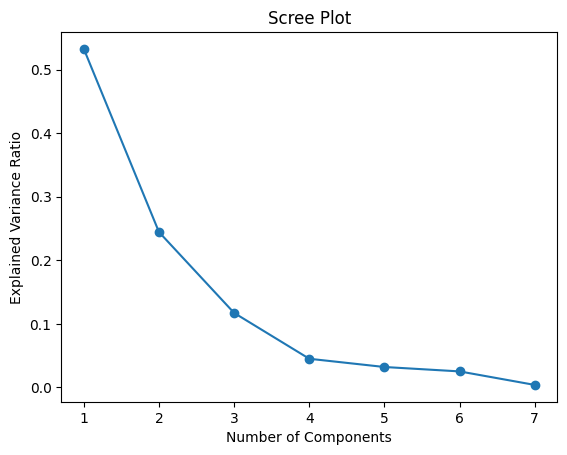

In [34]:
# Normalize for PCA
scaler = StandardScaler()
df_scaled = df.copy() # using df with 2023 data

# Select numeric cols
numeric_cols = [col for col in df.select_dtypes('number').columns if (col != "Year") & (col != "Enplanements")]
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Perform PCA 
pca = PCA() # Default n_components = number of existing features
pca.fit(df_scaled[numeric_cols])


# Select n_components:

# Option 1 (not chosen): Based on Explained Variance -> 6
explainedVariance = pca.explained_variance_ratio_
explainedVariance_cum = np.cumsum(pca.explained_variance_ratio_)
explainedVariance_cum
# n_components = np.argmax(explainedVariance_cum >= 0.95) + 1 #np.argmax returns the index of the first occurence of max value ('1') - i.e. index of first element which satisfy the criteria >0.95
# n_components #np.int64(6)

# Option 2 (chosen): Based on Visual inspection of Scree plot using Elbow method -> 3
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show() # choose n=3

- Elbow observed at n=3

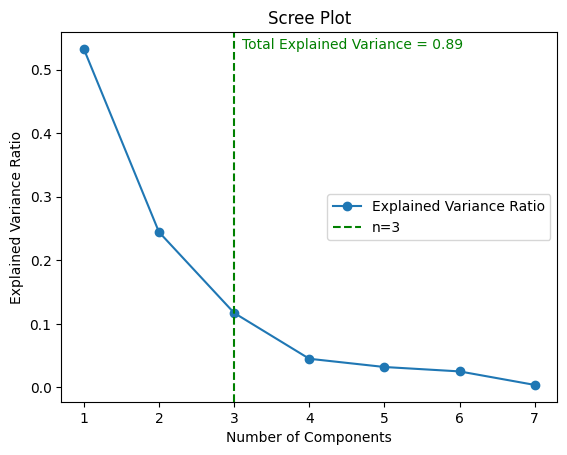

In [35]:
# Final Scree Plot

# Option 2 (chosen): Based on visual inspection -> 3 components
n_components = 3
explained_variance_at_3 = explainedVariance_cum[n_components - 1]  # Cumulative explained variance at PC = 3

# Plot Scree Plot with vertical line at n = 3
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o', label='Explained Variance Ratio')

# Add vertical line at PC = 3
plt.axvline(x=n_components, color='g', linestyle='--', label=f'n={n_components}')

# Annotate with explained variance at PC = 3
plt.text(n_components + 0.1, explainedVariance[0], f'Total Explained Variance = {explained_variance_at_3:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Save and show plot
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

In [36]:
# Perform final PCA with 3 components
n=3
pca = PCA(n_components=n)
pca_result = pca.fit_transform(df_scaled[numeric_cols])

# PCA results 
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n)])
# Concatenate the original data with PCA components
pca_df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)
pca_df.to_csv('assets/pca_df.csv', index=None) 
pca_df.head()

,State Name,Enplanements,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Code (USPS),PC1,PC2,PC3
0,Alabama,6.697678e+05,62212.0,35046.0,0.4771,5108468.0,216600.0,01,2023,0.018804,0.039766,AL,-1.767545,1.062621,-0.396554
1,Alaska,2.112405e+05,86631.0,45792.0,0.4492,733406.0,347500.0,02,2023,0.023868,0.074408,AK,0.121577,-1.008624,-0.586659
2,Arizona,1.227266e+07,77315.0,41290.0,0.4650,7431344.0,411200.0,04,2023,0.020882,0.131999,AZ,0.357048,0.016502,0.373212
3,Arkansas,1.096748e+06,58700.0,33012.0,0.4740,3067732.0,195700.0,05,2023,0.019464,0.052919,AR,-2.005391,1.181328,-0.427821
4,California,5.954076e+06,95521.0,48013.0,0.4870,38965193.0,725800.0,06,2023,0.028509,0.273065,CA,5.348914,1.898134,2.736928


In [37]:
# pca_df.head()
print(pca_df.isnull().sum())


State Name                         0
Enplanements                       0
Median Household Income            0
Per Capita Income                  0
Gini Index of Income Inequality    0
Total Population                   0
Median Home Value                  0
State Code (FIPS)                  0
Year                               0
Unemployment Rate                  0
Percent Foreigners                 0
State Code (USPS)                  0
PC1                                0
PC2                                0
PC3                                0
dtype: int64


In [38]:
# Look into how the original features contribute to each PC's

# Component contributions (loadings)
component_cont = pca.components_
# component_cont
pca_components_df = pd.DataFrame(component_cont, columns=numeric_cols, index=[f'PC{i+1}' for i in range(n)])
pca_components_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Home Value,Unemployment Rate,Percent Foreigners
PC1,0.414842,0.414619,0.268479,0.256794,0.409420,0.375605,0.457459
PC2,-0.430131,-0.304624,0.523909,0.435944,-0.334228,0.364762,0.113597
PC3,0.045380,-0.348077,-0.461532,0.657799,0.142070,-0.329789,0.319573


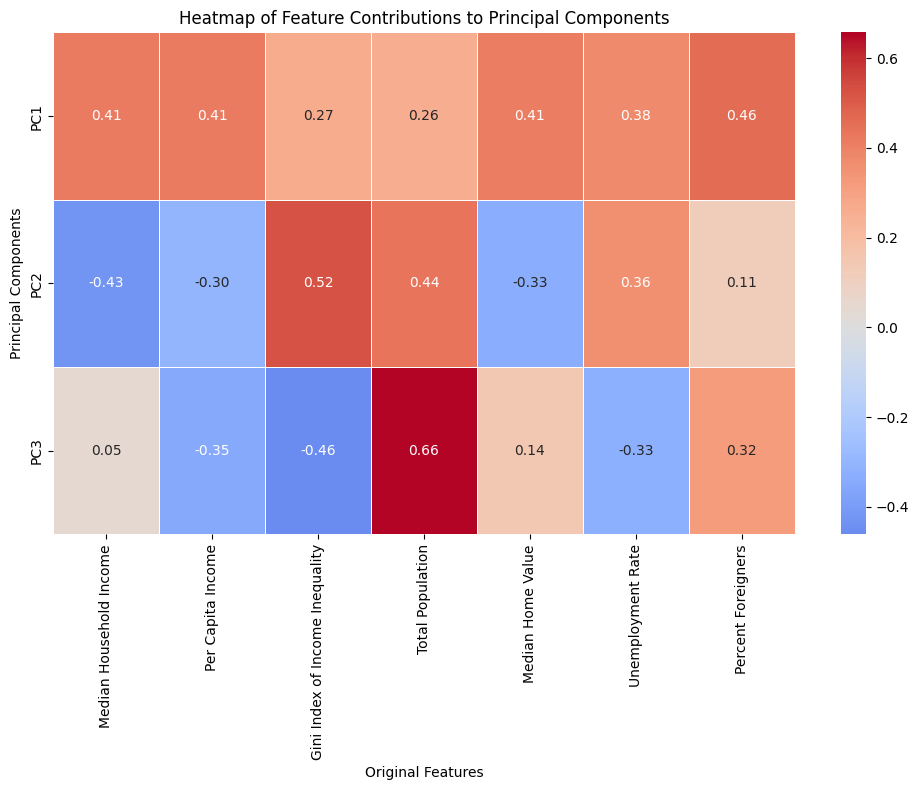

In [39]:
# Create a heatmap to visualize the component contributions (loadings)
plt.figure(figsize=(10, 8))
sns.heatmap(pca_components_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

# Set plot labels and title
plt.title('Heatmap of Feature Contributions to Principal Components')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')

# Show the heatmap
plt.tight_layout()
plt.savefig('visualizations/pca_component_contribution_heatmap.png',dpi=300)
plt.show()

**Main PC Components** 
- PC1: Percent Foreigners, Income (Household & Per Capita), Home Value
- PC2: Gini Index, Total Population, Household Income
- PC3: Total Population, Gini Index

PC1 explains 53.27% of the total variance


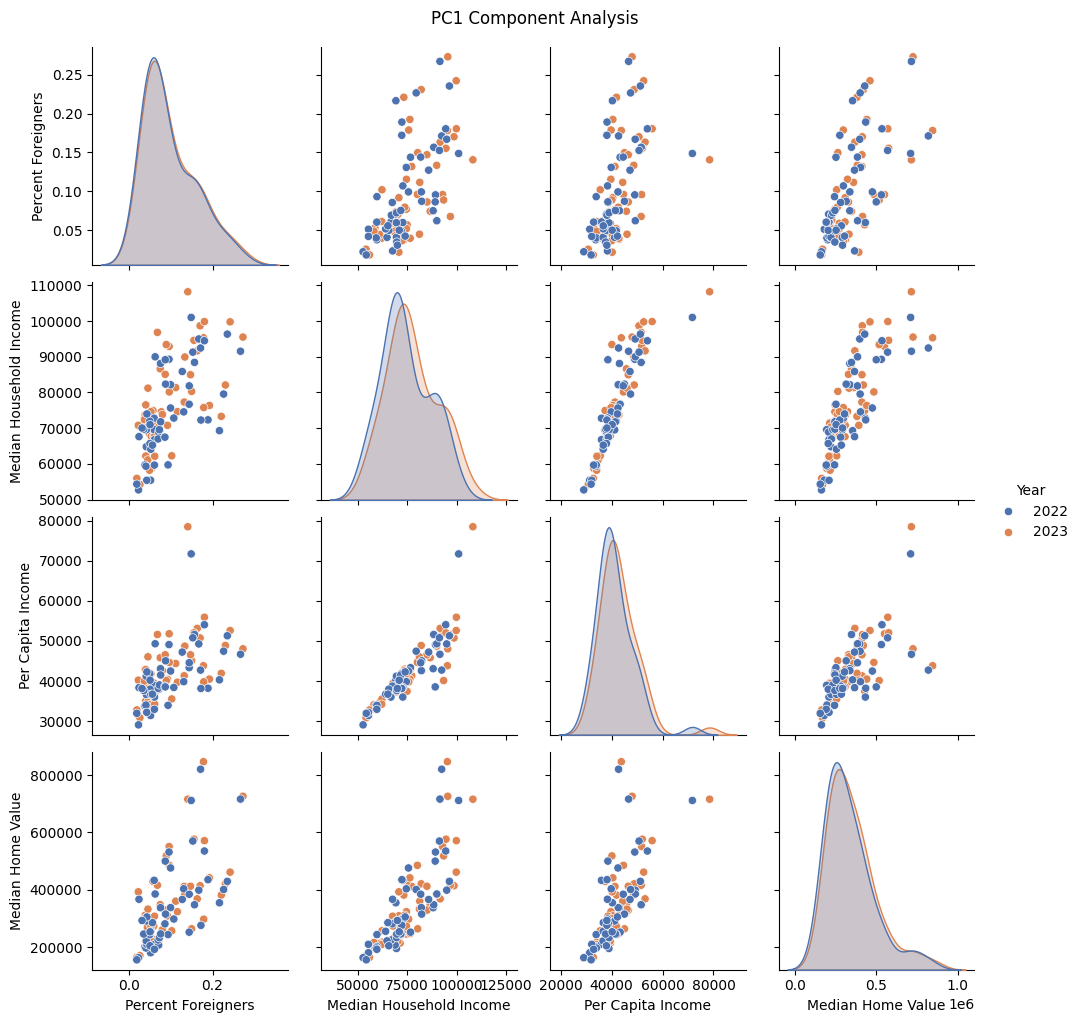

In [40]:
# Analyse PC1 on the original df with both 2022 and 2023 data

# Explained Variance by each component
explainedVariance_byComponent = pca.explained_variance_ratio_

explainedVariance_PC1 = explainedVariance_byComponent[0]
print(f"PC1 explains {explainedVariance_PC1*100:.2f}% of the total variance")

# Create a SPLOM for Main components of PC1 identified earlier
main_cols_pc1 = ['Percent Foreigners','Median Household Income', 'Per Capita Income', 'Median Home Value']
img_name_pc1 = 'acs_PC1_SPLOMs'
cols = main_cols_pc1
img_name = img_name_pc1

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC1 Component Analysis', y=1.02) 
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC1**
- Main components of PC1 are linearly correlated. PC1 here aligns with the directions where the most correlated features exist—because these correlations reflect the shared structure in the data.
- The first principal component (PC1) captures the largest proportion of variance. If features are correlated, they will share a significant portion of this variance, and PC1 will represent this shared variance.
- Similar trends for both 2022 and 2023.

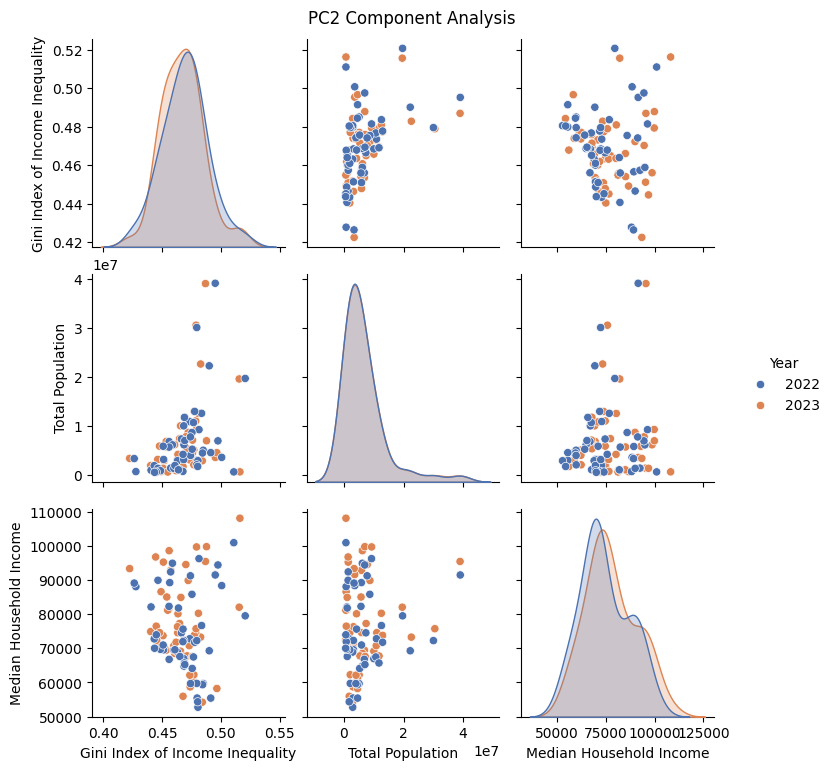

In [41]:
# Analyse PC2
# Main features for PC2
main_cols_pc2 = ['Gini Index of Income Inequality','Total Population','Median Household Income']
img_name_pc2 = 'acs_PC2_SPLOMs'
cols = main_cols_pc2
img_name = img_name_pc2

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC2 Component Analysis', y=1.02) 
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC2**
- Much weaker correlations than PC1 components
- Similar trends for both 2022 and 2023, although Median Household Income shifts up slightly

### MDS

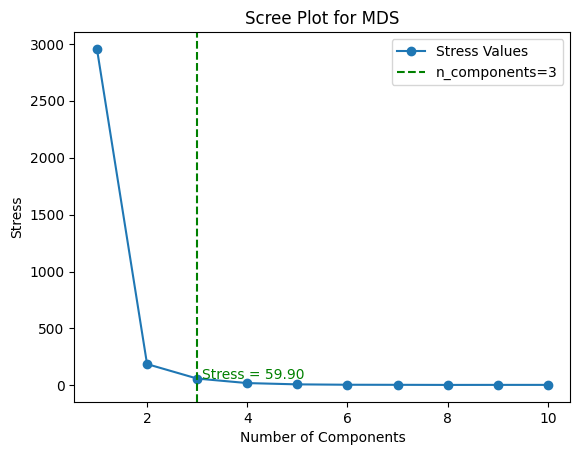

In [42]:
X = df_scaled[numeric_cols]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run MDS for different numbers of components
stress_values = []
n_components_range = np.arange(1, 11)  # Try MDS with 1 to 10 dimensions

for n_components in n_components_range:
    mds = MDS(n_components=n_components, random_state=42)
    mds.fit(X_scaled)
    stress_values.append(mds.stress_)

# Find optimal number of components (elbow point)
optimal_n_components = 3  # Based on visual inspection

# Plot scree-like plot for MDS stress
plt.plot(n_components_range, stress_values, marker='o', label='Stress Values')

# Add vertical line at the chosen n_components
plt.axvline(x=optimal_n_components, color='g', linestyle='--', label=f'n_components={optimal_n_components}')

# Annotate with stress at the chosen n_components
plt.text(optimal_n_components + 0.1, stress_values[optimal_n_components - 1], 
         f'Stress = {stress_values[optimal_n_components - 1]:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Stress')
plt.title('Scree Plot for MDS')

# Save and show plot
img_name = 'MDS_Stress_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()


In [43]:
# Perform MDS with n_components = 3
n=3
mds = MDS(n_components=n, random_state=42)

# MDS results 
mds_result = mds.fit_transform(df_scaled[numeric_cols])
mds_df = pd.DataFrame(mds_result, columns=[f'MDS_D{i+1}' for i in range(n)])
# Concatenate the original data with mds components
mds_df = pd.concat([df.reset_index(drop=True), mds_df], axis=1)
mds_df.to_csv('assets/mds_df.csv', index=None) 
mds_df.head()

,State Name,Enplanements,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Code (USPS),MDS_D1,MDS_D2,MDS_D3
0,Alabama,6.697678e+05,62212.0,35046.0,0.4771,5108468.0,216600.0,01,2023,0.018804,0.039766,AL,0.872173,-1.019708,-1.736064
1,Alaska,2.112405e+05,86631.0,45792.0,0.4492,733406.0,347500.0,02,2023,0.023868,0.074408,AK,-0.838214,-1.202310,1.061764
2,Arizona,1.227266e+07,77315.0,41290.0,0.4650,7431344.0,411200.0,04,2023,0.020882,0.131999,AZ,0.062422,0.130842,0.386155
3,Arkansas,1.096748e+06,58700.0,33012.0,0.4740,3067732.0,195700.0,05,2023,0.019464,0.052919,AR,0.971695,-1.477624,-1.692644
4,California,5.954076e+06,95521.0,48013.0,0.4870,38965193.0,725800.0,06,2023,0.028509,0.273065,CA,1.654880,5.790125,2.169267


## Clustering

### KMeans

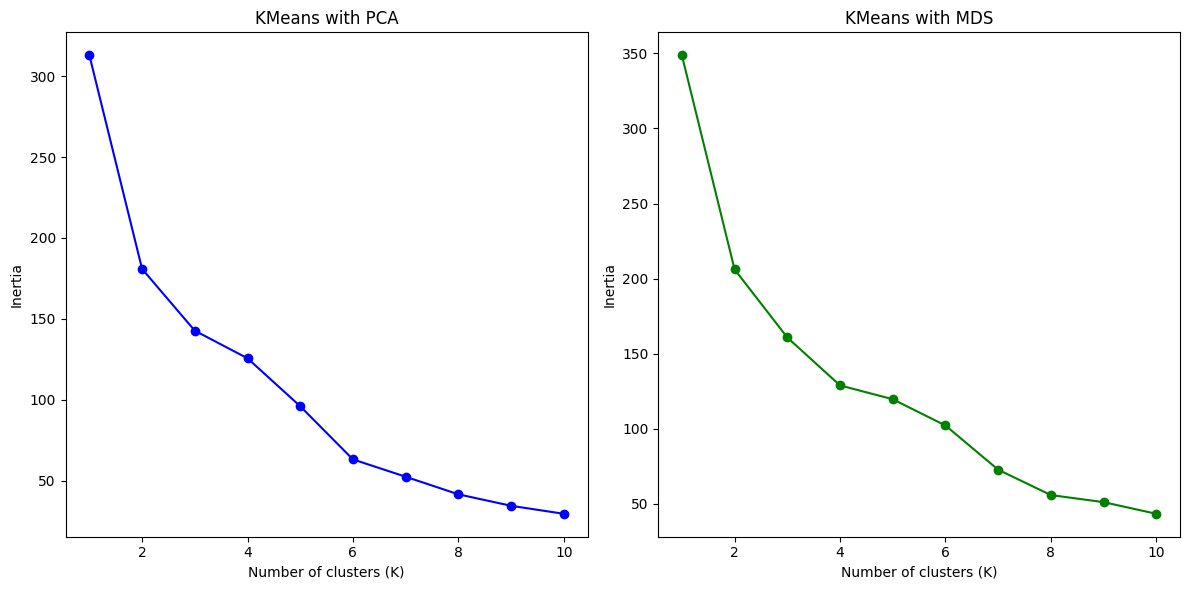

In [44]:
# Perform KMeans Clustering on PCA results (PCA + KMeans)
pca_cols = [col for col in pca_df.columns if 'PC' in col]
mds_cols = [col for col in mds_df.columns if 'MD' in col]

# Find most appropriate number of clusters
# Define range of K values
K = range(1, 11)

# Store inertia values for each K
# Inertia = within-cluster sum of squares (WCSS) 
inertia_pca = []
inertia_mds = []

for k in K:
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(pca_df[pca_cols])
    inertia_pca.append(kmeans_pca.inertia_)

    kmeans_mds = KMeans(n_clusters=k, random_state=42)
    kmeans_mds.fit(mds_df[mds_cols])
    inertia_mds.append(kmeans_mds.inertia_)

# Plot the Elbow Method graph
img_name = 'KMeans_Elbow'
plt.figure(figsize=(12, 6))  # Set the figure size to be more readable

# Plot for KMeans with PCA
plt.subplot(1, 2, 1)  # First subplot
plt.plot(K, inertia_pca, 'bo-', label='Inertia with PCA')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans with PCA')

# Plot for KMeans with MDS
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(K, inertia_mds, 'go-', label='Inertia with MDS')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans with MDS')

# Save the figure with the correct image name
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.tight_layout() 
plt.show()



- Choose a common K based on Elbow Methdo: K=3

In [45]:
# Let's compare silhoutte score for PCA+KMeans vs MDS+KMeans

K=3
kmeans_pca = KMeans(n_clusters=K,random_state=42)
# kmeans_pca.fit(pca_df[pca_cols])
# labels_pca = kmeans_pca.labels_
labels_pca = kmeans_pca.fit_predict(pca_df[pca_cols])

kmeans_mds = KMeans(n_clusters=K,random_state=42)
kmeans_mds.fit(mds_df[mds_cols])
labels_mds = kmeans_mds.labels_

# Compute silhouette scores
silhouette_score_pca = silhouette_score(pca_df[pca_cols], labels_pca)
silhouette_score_mds = silhouette_score(mds_df[mds_cols], labels_mds)
print(f'Silhouette Score for PCA + KMeans: {silhouette_score_pca}')
print(f'Silhouette Score for MDS + KMeans: {silhouette_score_mds}')

Silhouette Score for PCA + KMeans: 0.3972347508501571
Silhouette Score for MDS + KMeans: 0.3176210429142581


PCA + KMeans gives better clusters based on silhouette score.

In [46]:
# Create a final df to store KMean clusters of data transformed various ways, for ease of visualizations
kmeans_df = pca_df.copy()
kmeans_df['MDS_D1'] = mds_df['MDS_D1']
kmeans_df['MDS_D2'] = mds_df['MDS_D2']
kmeans_df['MDS_D3'] = mds_df['MDS_D3']

kmeans_df["KMeans_PCA Clusters"] = labels_pca
kmeans_df["KMeans_MDS Clusters"] = labels_mds
# kmeans_df.to_csv('assets/kmeans_df.csv',index=None)
kmeans_df.head()

,State Name,Enplanements,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Code (USPS),PC1,PC2,PC3,MDS_D1,MDS_D2,MDS_D3,KMeans_PCA Clusters,KMeans_MDS Clusters
0,Alabama,6.697678e+05,62212.0,35046.0,0.4771,5108468.0,216600.0,01,2023,0.018804,0.039766,AL,-1.767545,1.062621,-0.396554,0.872173,-1.019708,-1.736064,0,2
1,Alaska,2.112405e+05,86631.0,45792.0,0.4492,733406.0,347500.0,02,2023,0.023868,0.074408,AK,0.121577,-1.008624,-0.586659,-0.838214,-1.202310,1.061764,1,0
2,Arizona,1.227266e+07,77315.0,41290.0,0.4650,7431344.0,411200.0,04,2023,0.020882,0.131999,AZ,0.357048,0.016502,0.373212,0.062422,0.130842,0.386155,1,1
3,Arkansas,1.096748e+06,58700.0,33012.0,0.4740,3067732.0,195700.0,05,2023,0.019464,0.052919,AR,-2.005391,1.181328,-0.427821,0.971695,-1.477624,-1.692644,0,2
4,California,5.954076e+06,95521.0,48013.0,0.4870,38965193.0,725800.0,06,2023,0.028509,0.273065,CA,5.348914,1.898134,2.736928,1.654880,5.790125,2.169267,2,1


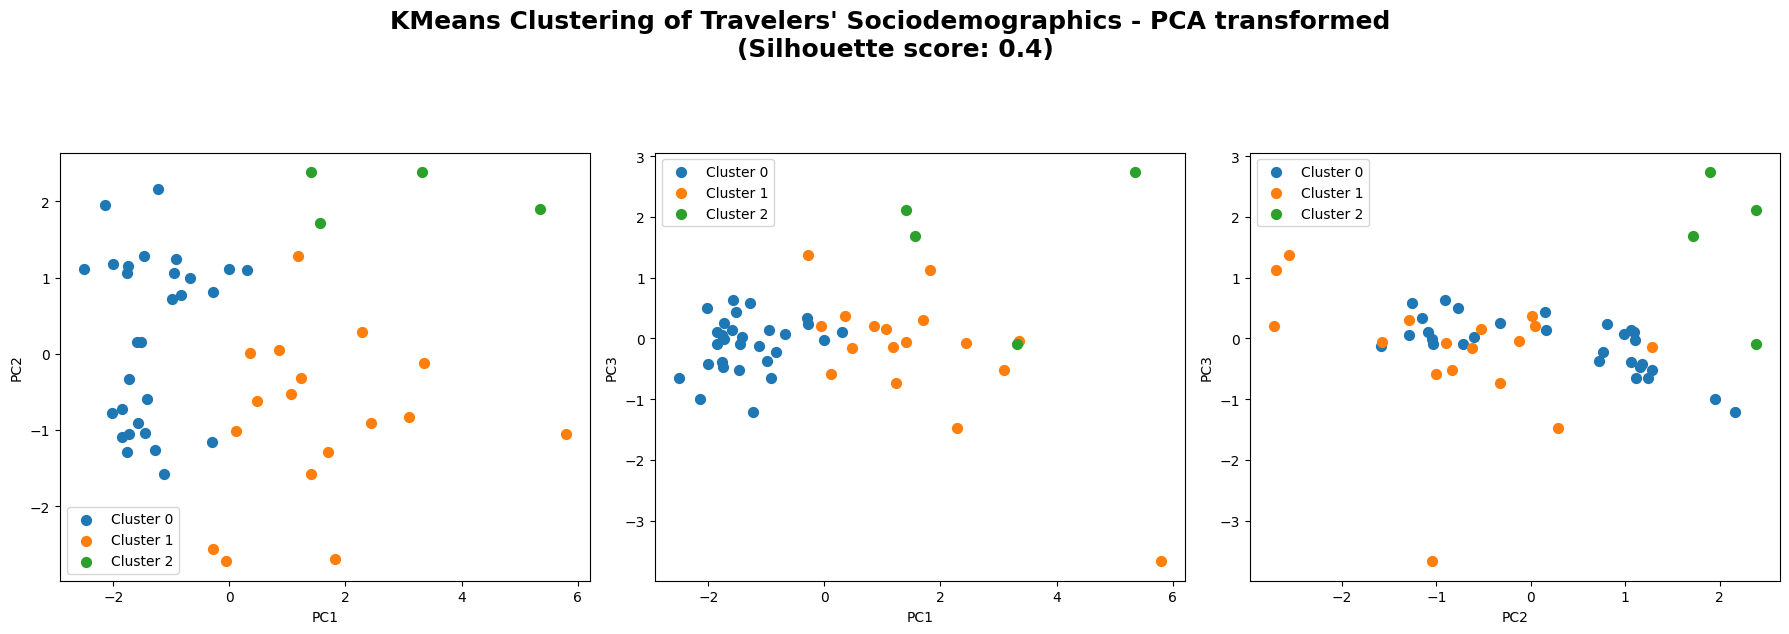

In [51]:
# Define the DataFrame with PCA columns and clusters
tmp = kmeans_df

# Separate plot for PCA
plt.figure(figsize=(6*3,6))  # Set figure size for PCA
plt.suptitle(f'KMeans Clustering of Travelers\' Sociodemographics - PCA transformed \n(Silhouette score: {round(silhouette_score_pca,2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['PC1', 'PC2', 'PC3']

# Scatter plot PC1 vs PC2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in tmp['KMeans_PCA Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_PCA Clusters'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Scatter plot PC1 vs PC3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in tmp['KMeans_PCA Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_PCA Clusters'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.legend()

# Scatter plot PC2 vs PC3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in tmp['KMeans_PCA Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_PCA Clusters'] == cluster]
    plt.scatter(cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend()

# Adjust layout and save the PCA plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/KMeans_Clusters_PCA.png')
plt.show()

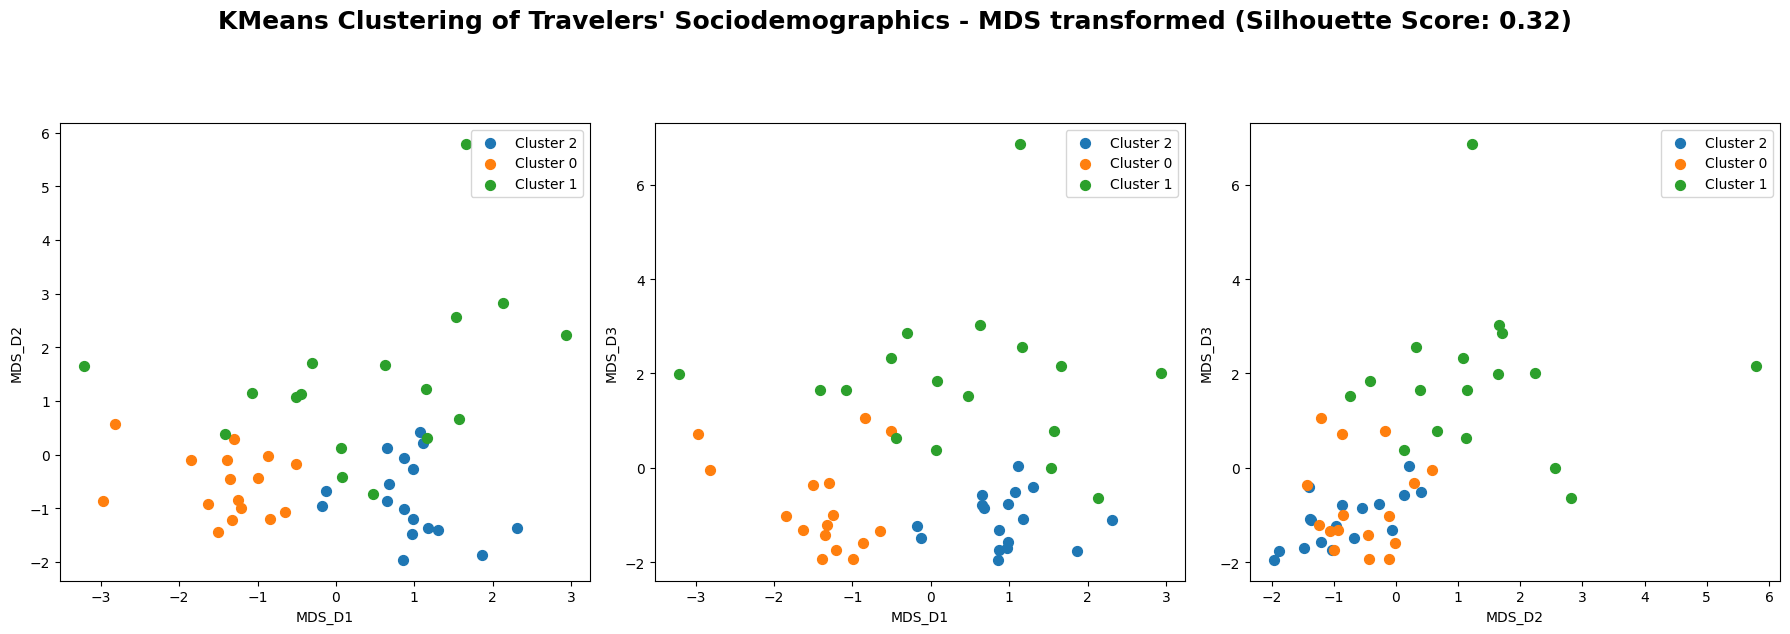

In [50]:
# Separate plot for MDS
plt.figure(figsize=(6*3, 6))  # Set figure size for MDS
plt.suptitle(f'KMeans Clustering of Travelers\' Sociodemographics - MDS transformed (Silhouette Score: {round(silhouette_score_mds,2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['MDS_D1', 'MDS_D2', 'MDS_D3']

# Scatter plot MDS_D1 vs MDS_D2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in tmp['KMeans_MDS Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_MDS Clusters'] == cluster]
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D2'], label=f'Cluster {cluster}', s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D2')
plt.legend()

# Scatter plot MDS_D1 vs MDS_D3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in tmp['KMeans_MDS Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_MDS Clusters'] == cluster]
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D3')
plt.legend()

# Scatter plot MDS_D2 vs MDS_D3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in tmp['KMeans_MDS Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_MDS Clusters'] == cluster]
    plt.scatter(cluster_data['MDS_D2'], cluster_data['MDS_D3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('MDS_D2')
plt.ylabel('MDS_D3')
plt.legend()

# Adjust layout and save the MDS plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/KMeans_Clusters_MDS.png')
plt.show()

### DBSCAN

In [55]:
# pca+DBSCAN
# Set up parameters
eps_values = [0.9, 1, 1.1, 1.2]
min_samples_values = [5, 6, 7, 8]

X = pca_df[pca_cols].copy()

# OPTIMIZATION
best_eps = None
best_min_samples = None
best_noise_points = None
best_score = -1

# Loop over eps and min_samples values to find the best silhouette score
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        if len(set(labels)) > 2:  # Avoids the case where there's one cluster and noise
            score = silhouette_score(X, labels)
            noise_points = np.sum(labels == -1)
            total_points = len(labels)
            print(f"eps: {eps}, min_samples: {min_samples}, score: {score}, and {noise_points}/{total_points} noise points")
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_noise_points = noise_points

print(f"Best eps: {best_eps}, best min_samples: {best_min_samples} with Silhouette score: {best_score}, and {best_noise_points}/{total_points} noise points")

eps: 0.9, min_samples: 5, score: 0.1937152474637954, and 19/50 noise points
eps: 0.9, min_samples: 6, score: 0.25573739586965016, and 24/50 noise points
eps: 0.9, min_samples: 7, score: 0.24830533374921282, and 25/50 noise points
eps: 0.9, min_samples: 8, score: 0.19640543350662007, and 28/50 noise points
eps: 1, min_samples: 5, score: 0.13653607982914948, and 16/50 noise points
eps: 1, min_samples: 7, score: 0.24947330766485365, and 24/50 noise points
eps: 1, min_samples: 8, score: 0.24947330766485365, and 24/50 noise points
eps: 1.1, min_samples: 6, score: 0.1849048762652274, and 14/50 noise points
eps: 1.1, min_samples: 7, score: 0.13584337811601854, and 16/50 noise points
eps: 1.2, min_samples: 7, score: 0.19744241486235392, and 12/50 noise points
Best eps: 0.9, best min_samples: 6 with Silhouette score: 0.25573739586965016, and 24/50 noise points


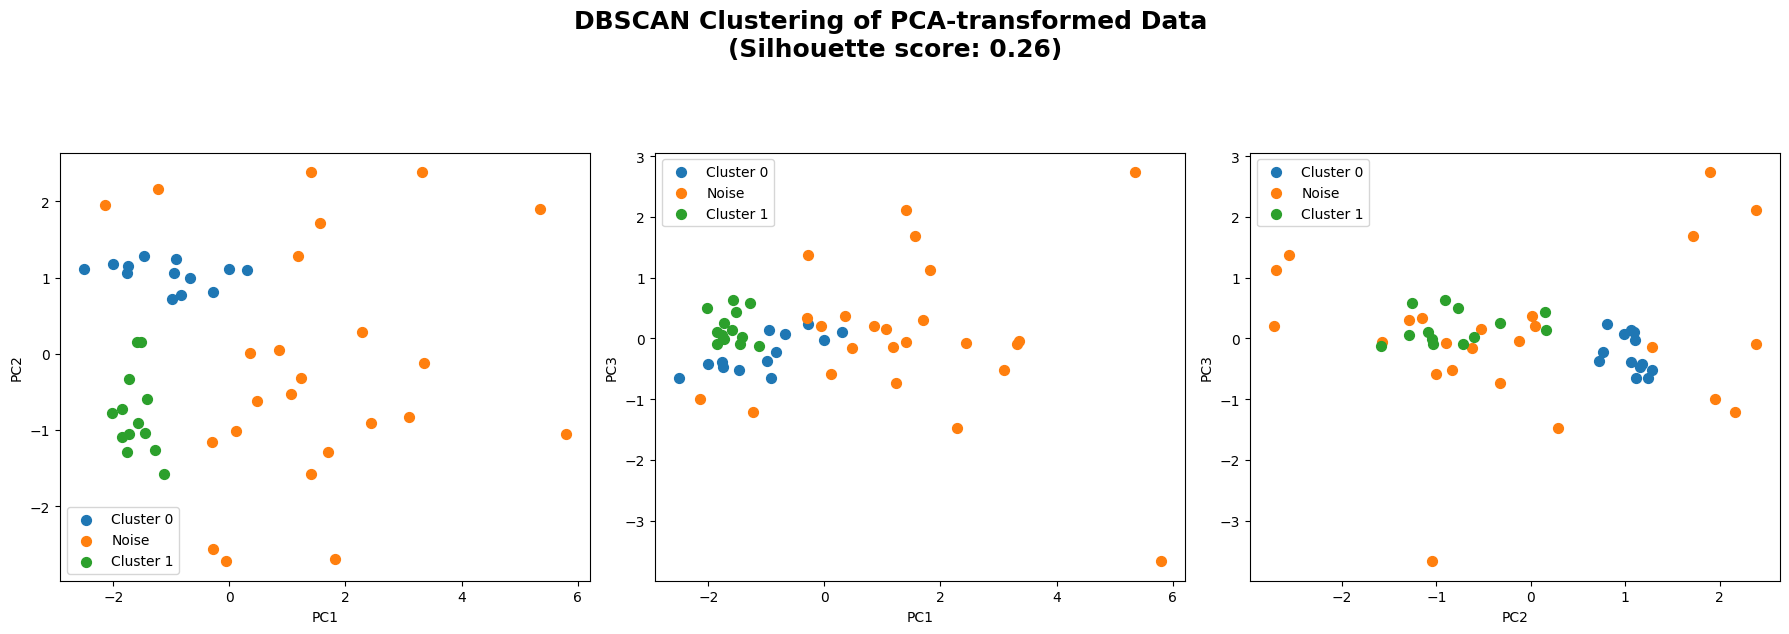

In [54]:
# pca+DBSCAN Clustering (assuming best parameters are already found)
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = dbscan_best.fit_predict(X)

# Define a DataFrame with PCA components for better alignment with other plots
pca_df_dbscan = pd.DataFrame(X, columns=['PC1', 'PC2', 'PC3'])
pca_df_dbscan['DBSCAN Clusters'] = best_labels

# Calculate silhouette score for DBSCAN
if len(set(best_labels)) > 1:  # Check if there are more than one cluster
    silhouette_score_dbscan = silhouette_score(X, best_labels)
else:
    silhouette_score_dbscan = -1  # Not applicable if there is only one cluster

# Separate plot for DBSCAN + PCA
plt.figure(figsize=(6*3, 6))  # Set figure size
plt.suptitle(f'DBSCAN Clustering of PCA-transformed Data \n(Silhouette score: {round(silhouette_score_dbscan, 2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['PC1', 'PC2', 'PC3']

# Scatter plot PC1 vs PC2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in pca_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = pca_df_dbscan[pca_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=label_name, s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Scatter plot PC1 vs PC3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in pca_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = pca_df_dbscan[pca_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['PC1'], cluster_data['PC3'], label=label_name, s=50)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.legend()

# Scatter plot PC2 vs PC3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in pca_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = pca_df_dbscan[pca_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['PC2'], cluster_data['PC3'], label=label_name, s=50)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend()

# Adjust layout and save the DBSCAN + PCA plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/DBSCAN_Clusters_PCA.png')
plt.show()


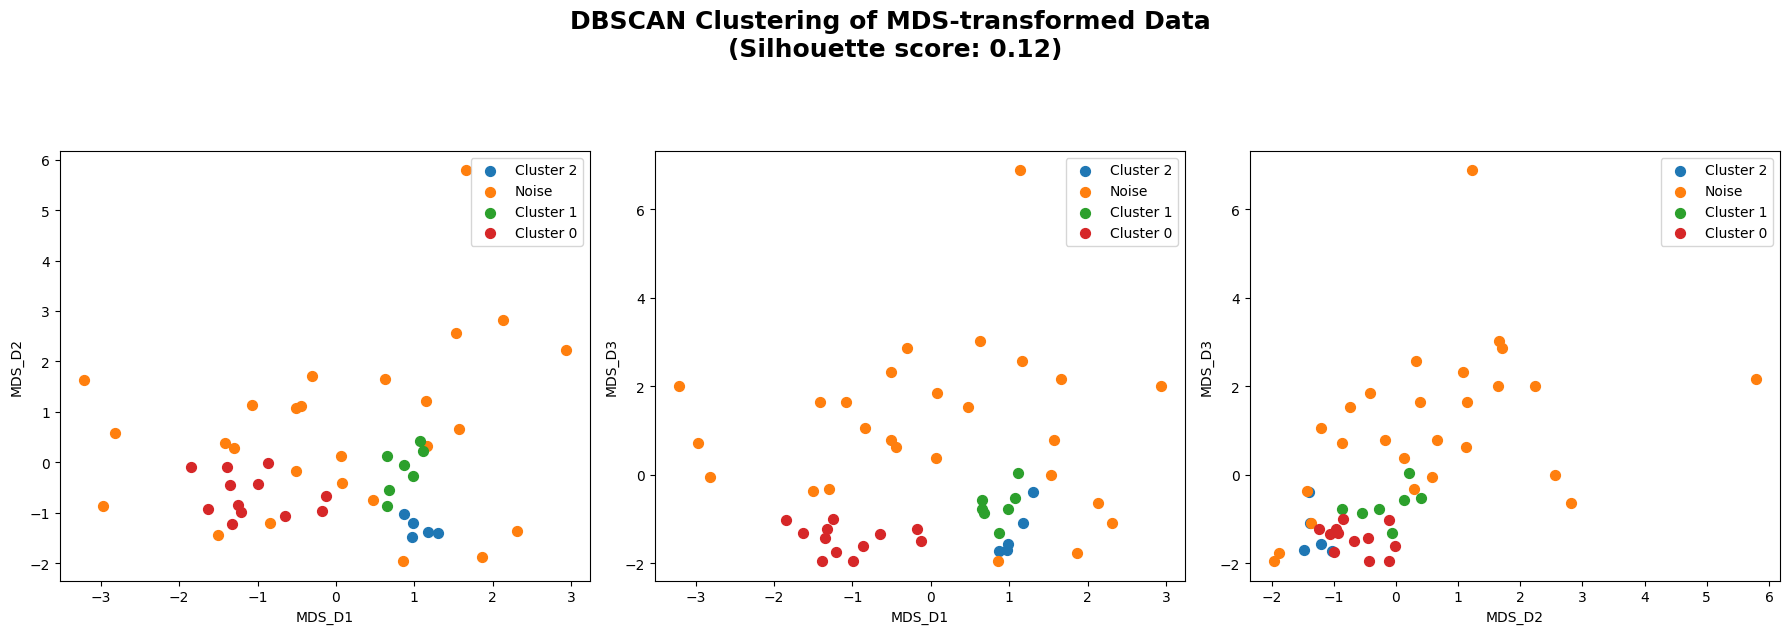

In [56]:
X = mds_df[mds_cols].copy()

# MDS +DBSCAN Clustering (for MDS-transformed data)
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels_mds = dbscan_best.fit_predict(X)

# Define a DataFrame with MDS components
mds_df_dbscan = pd.DataFrame(X, columns=['MDS_D1', 'MDS_D2', 'MDS_D3'])
mds_df_dbscan['DBSCAN Clusters'] = best_labels_mds

# Calculate silhouette score for DBSCAN on MDS-transformed data
if len(set(best_labels_mds)) > 1:  # Check if there are more than one cluster
    silhouette_score_mds = silhouette_score(X, best_labels_mds)
else:
    silhouette_score_mds = -1  # Not applicable if there is only one cluster

# Separate plot for DBSCAN + MDS
plt.figure(figsize=(6*3, 6))  # Set figure size
plt.suptitle(f'DBSCAN Clustering of MDS-transformed Data \n(Silhouette score: {round(silhouette_score_mds, 2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['MDS_D1', 'MDS_D2', 'MDS_D3']

# Scatter plot MDS_D1 vs MDS_D2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in mds_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = mds_df_dbscan[mds_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D2'], label=label_name, s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D2')
plt.legend()

# Scatter plot MDS_D1 vs MDS_D3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in mds_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = mds_df_dbscan[mds_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D3'], label=label_name, s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D3')
plt.legend()

# Scatter plot MDS_D2 vs MDS_D3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in mds_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = mds_df_dbscan[mds_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['MDS_D2'], cluster_data['MDS_D3'], label=label_name, s=50)
plt.xlabel('MDS_D2')
plt.ylabel('MDS_D3')
plt.legend()

# Adjust layout and save the MDS plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/DBSCAN_Clusters_MDS.png')
plt.show()
